In [1]:
import pkg_resources  # type: ignore
import rootutils

root = rootutils.setup_root(".", pythonpath=True)
print(root)


from name_detector.pipeline import TextPipeline, prepare_pipeline

config = {
    "chat_names_test_size": 3000,
    "crm_train_examples": 10000,
    # 'crm_train_examples': 1000,
    "vocab_size": 2000,
    "negative_test_size": 10000,
    # 'pipeline_path': '../name_detector/checkpoints/pipeline.joblib',
    "data_dir": f"{root}/data",
    "pipeline_path": pkg_resources.resource_filename("name_detector", f"checkpoints/pipeline.joblib"),
    "cb_model_path": pkg_resources.resource_filename("name_detector", f"checkpoints/catboost_model.cbm"),
    "only_cyrillic": False,
}
display(config)

result = prepare_pipeline(config)
pipeline: TextPipeline = result["pipeline"]
negative_train_examples = result["negative_train_examples"]
positive_train_examples = result["positive_train_examples"]
negative_test_examples = result["negative_test_examples"]
positive_test_examples = result["positive_test_examples"]

print("Loading pipeline...")
pipeline = TextPipeline.init_from(config["pipeline_path"])

/home/admin1/alif_projects/tajik_name_recognition


{'chat_names_test_size': 3000,
 'crm_train_examples': 10000,
 'vocab_size': 2000,
 'negative_test_size': 10000,
 'data_dir': '/home/admin1/alif_projects/tajik_name_recognition/data',
 'pipeline_path': '/home/admin1/alif_projects/tajik_name_recognition/name_detector/checkpoints/pipeline.joblib',
 'cb_model_path': '/home/admin1/alif_projects/tajik_name_recognition/name_detector/checkpoints/catboost_model.cbm',
 'only_cyrillic': False}

Loaded "data/names_in_chats.txt", size: 7640
Loaded "data/CRM_names.csv", size: 629618
Loaded "data/chat_messages.csv", size: 221669
Deduplicating...
names_in_chats: 7634
crm_names: 624092
negative_examples: 153075
Positive examples. Train: 19268, Test: 3000
Loaded base names, size: 64063
Preparing pipeline...
Training pipeline...
Pipeline saved at: /home/admin1/alif_projects/tajik_name_recognition/name_detector/checkpoints/pipeline.joblib
Loading pipeline...


In [2]:
print("Transforming train examples...")
NEG_COUNT = len(positive_train_examples) // 4
train_labels = [1] * len(positive_train_examples) + [0] * NEG_COUNT
X_train, y_train = pipeline.transform(
    positive_train_examples + negative_train_examples[:NEG_COUNT],
    train_labels,
    train=True,
)
train_texts = pipeline.preprocessed_texts

print("Transforming test examples...")
NEG_COUNT = config["negative_test_size"]
test_labels = [1] * len(positive_test_examples) + [0] * NEG_COUNT
X_test, y_test = pipeline.transform(
    positive_test_examples + negative_test_examples[:NEG_COUNT],
    test_labels,
    train=False,
)
test_texts = pipeline.preprocessed_texts

Transforming train examples...
Transforming test examples...


In [9]:
import numpy as np
import pandas as pd
from catboost import Pool

from name_detector.model import CatBoostModel

model_config = dict(
    auto_class_weights="Balanced",
    iterations=2000,
    learning_rate=0.2,
    depth=7,
    loss_function="Logloss",
    eval_metric="AUC",
    early_stopping_rounds=300,
    verbose=100,
)
model = CatBoostModel(model_config)

print(X_train.shape)
print(X_test.shape)

print("Creating train pools")
train_pool = Pool(data=X_train, label=y_train)

print("Creating test pools")
eval_pool = Pool(data=X_test, label=y_test)

print("Starting model training")
model.fit(train_pool, eval_set=eval_pool, use_best_model=True, plot=True)

# (113995, 12015)
# (141076, 12015)
# (1716516, 12015)
# (12690, 12015)
# bestTest = 0.9988213872
# bestTest = 0.9989275122

(340686, 6015)
(12680, 6015)
Creating train pools
Creating test pools
Starting model training


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9841720	best: 0.9841720 (0)	total: 407ms	remaining: 13m 32s
100:	test: 0.9988358	best: 0.9988400 (99)	total: 28.3s	remaining: 8m 51s
200:	test: 0.9989069	best: 0.9989200 (190)	total: 52.6s	remaining: 7m 50s
300:	test: 0.9988232	best: 0.9989200 (190)	total: 1m 16s	remaining: 7m 11s
400:	test: 0.9988133	best: 0.9989200 (190)	total: 1m 41s	remaining: 6m 44s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.9989199822
bestIteration = 190

Shrink model to first 191 iterations.


In [10]:
from sklearn.metrics import classification_report

# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Print misclassified examples
threshold = 0.1
y_pred = (y_proba > threshold)[:, 1]
misclassified_indices = np.where(y_pred != y_test)[0]
print("\nMisclassified Examples:")
for index in misclassified_indices:
    print(f"Actual: {y_test[index]}, Predicted: {y_pred[index]}, Text: {test_texts[index]}")

# Current best:
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00      9692
#            1       0.98      0.99      0.99      2998

#     accuracy                           0.99     12690
#    macro avg       0.99      0.99      0.99     12690
# weighted avg       0.99      0.99      0.99     12690

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9681
           1       0.98      0.99      0.99      2999

    accuracy                           0.99     12680
   macro avg       0.99      0.99      0.99     12680
weighted avg       0.99      0.99      0.99     12680


Misclassified Examples:
Actual: 1, Predicted: False, Text: ['Arshad', 'Talha', 'HV']
Actual: 1, Predicted: False, Text: ['Абдикарим', 'уулу', 'Музафар']
Actual: 1, Predicted: False, Text: ['Абратна', 'мебиёя']
Actual: 1, Predicted: False, Text: ['чокаден', 'дидем']
Actual: 1, Predicted: False, Text: ['Кушнир', 'В', 'Б']
Actual: 1, Predicted: False, Text: ['Дамир', 'маркет']
Actual: 0, Predicted: True, Text: ['Ном', 'Шахиди', 'Фархидин']
Actual: 0, Predicted: True, Text: ['Для', 'Миджгоны']
Actual: 0, Predicted: True, Text: ['Дар', 'Икдоми', 'Калон']
Actual: 0, Predicted: True, Text: ['Ман', 'забиров', 'Бехзод']
Actual: 0, Predicted: True, Text: ['Интизорам', 'Хохи

In [11]:
def predict_example(text):
    features = pipeline.transform([text], [0])[0].toarray()
    # print("features:", features)
    pred = model.predict_proba(features)[0]
    print(f"{text:30s} {pred[1]:.3f}")


for example in [
    "алимов исломуддин",
    "алимов исломуддин hastam",
    "алимов hastam",
    "rustam hastam",
    "пайваст буд",
    "ИДИЕВ РЕЗВОН",
    "GHOZIEV ZAVKIBEK",
    "мукаддас курбонова",
    "ғуломов мустафо",
    "ghulomov mustafo",
    "Khuni tojiki",
    "harfi khub",
    "parvo nakun",
    "pul partoftam",
    "Faqat Bekoram",
    "furqat salim",
    "kokhi borbad",
    "dunyoi osh",
    "james wilson",
]:
    predict_example(example)

алимов исломуддин              0.954
алимов исломуддин hastam       0.736
алимов hastam                  0.724
rustam hastam                  0.023
пайваст буд                    0.005
ИДИЕВ РЕЗВОН                   0.179
GHOZIEV ZAVKIBEK               0.715
мукаддас курбонова             0.955
ғуломов мустафо                0.992
ghulomov mustafo               0.879
Khuni tojiki                   0.081
harfi khub                     0.050
parvo nakun                    0.005
pul partoftam                  0.032
Faqat Bekoram                  0.410
furqat salim                   0.082
kokhi borbad                   0.041
dunyoi osh                     0.145
james wilson                   0.006


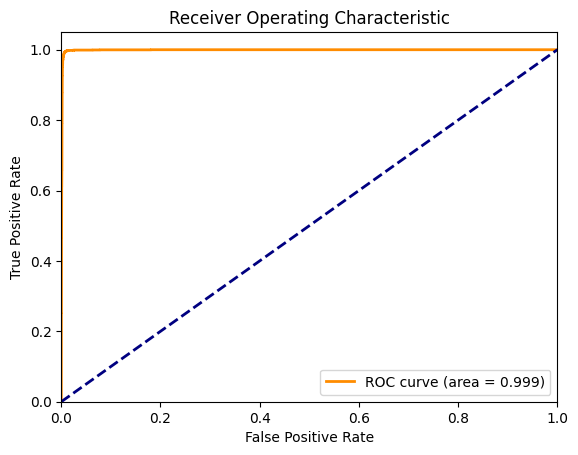

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

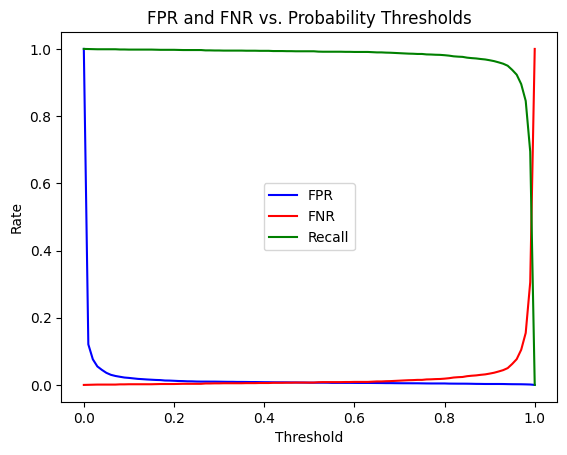

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def calculate_fpr_fnr(y_true, y_pred_proba, thresholds):
    fpr_list = []
    fnr_list = []
    recall_list = []

    for thresh in thresholds:
        # Apply threshold
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)

        # Calculate confusion matrix
        TN, FP, FN, TP = confusion_matrix(y_true, y_pred_thresh).ravel()

        # Calculate FPR and FNR
        FPR = FP / (FP + TN)
        FNR = FN / (FN + TP)
        recall = TP / (TP + FN)

        fpr_list.append(FPR)
        fnr_list.append(FNR)
        recall_list.append(recall)

    return fpr_list, fnr_list, recall_list


# Define thresholds
thresholds = np.linspace(0, 1, 101)

# Calculate FPR and FNR
fpr_list, fnr_list, recall_list = calculate_fpr_fnr(y_test, y_pred_proba, thresholds)


# Plot FPR and FNR
plt.figure()
plt.plot(thresholds, fpr_list, label="FPR", color="blue")
plt.plot(thresholds, fnr_list, label="FNR", color="red")
plt.plot(thresholds, recall_list, label="Recall", color="green")

# Adding titles and labels
plt.title("FPR and FNR vs. Probability Thresholds")
plt.ylabel("Rate")
plt.xlabel("Threshold")
plt.legend()
plt.show()

In [14]:
pd.DataFrame({"fpr": fpr_list, "fnr": fnr_list, "recall": recall_list, "thresh": thresholds}).iloc[::5, :]

,fpr,fnr,recall,thresh
0,1.000000,0.000000,1.000000,0.00
5,0.035947,0.001000,0.999000,0.05
10,0.020866,0.002001,0.997999,0.10
15,0.015494,0.002001,0.997999,0.15
20,0.012292,0.002668,0.997332,0.20
25,0.010123,0.003334,0.996666,0.25
30,0.009606,0.004668,0.995332,0.30
35,0.008883,0.005002,0.994998,0.35
40,0.008160,0.005669,0.994331,0.40
45,0.007644,0.006669,0.993331,0.45


In [15]:
if input("Save CatBoost model?") == "y":
    model.save("../name_detector/checkpoints/catboost_model.cbm")